In [1]:
import torch
from torch.optim import Adam

import pickle
import soundfile as sf
import IPython.display as ipd

from constants import *
from train import train_model
from early_stopper import EarlyStopper

from phase_loss import PhaseLoss
from magnitude_loss import MagnitudeLoss

from polar_dataset import build_data_loaders
from disk_utils import save_model, load_model
from plotter import plot_loss, plot_heatmaps, plot_waves
from predict import predict_polar, get_phases, make_wav

from models.model_0 import Model_0

In [2]:
USE_GPU = True

num_epochs = 250
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not USE_GPU:
    device = torch.device("cpu")
    num_epochs = 1

In [3]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

model = Model_0(1, 32)

part = "db"
train_data_loader, test_data_loader = build_data_loaders(
    min_max, part=part, test_size=test_size)

criterion = MagnitudeLoss(
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part]
)
optimizer = Adam(model.parameters(), lr=3e-4)
es = EarlyStopper(7, 3e-6)

In [4]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    device,
    train_data_loader, test_data_loader,
    es,
    num_epochs=num_epochs
)

Starting training...
E: 001/250	 T: 191.240840	 V: 107.360839
E: 002/250	 T: 72.015462	 V: 97.614074
E: 003/250	 T: 54.451475	 V: 76.507385
E: 004/250	 T: 47.161874	 V: 81.137745
E: 005/250	 T: 43.302931	 V: 70.778534
E: 006/250	 T: 39.333954	 V: 99.229836
E: 007/250	 T: 35.410808	 V: 73.147315
E: 008/250	 T: 33.676348	 V: 73.656959
E: 009/250	 T: 31.570652	 V: 72.284348
E: 010/250	 T: 32.270542	 V: 71.406243
E: 011/250	 T: 30.121251	 V: 68.772210
E: 012/250	 T: 27.726596	 V: 71.082273
E: 013/250	 T: 32.165784	 V: 72.083405
E: 014/250	 T: 26.530959	 V: 74.383741
E: 015/250	 T: 26.966957	 V: 73.023886
E: 016/250	 T: 25.171669	 V: 74.289949
E: 017/250	 T: 24.327038	 V: 71.427286
E: 018/250	 T: 25.524073	 V: 67.219336
E: 019/250	 T: 25.122265	 V: 76.033929
E: 020/250	 T: 24.762421	 V: 72.365523
E: 021/250	 T: 24.731124	 V: 78.050427
E: 022/250	 T: 23.130261	 V: 71.742465
E: 023/250	 T: 22.636302	 V: 72.962221
E: 024/250	 T: 22.953934	 V: 82.178125
E: 025/250	 T: 23.227377	 V: 75.900762
St

In [5]:
model.to(torch.device("cpu"))

Model_0(
  (enc1): ConvBlock(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Tanh()
  )
  (enc2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Tanh()
  )
  (enc3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Tanh()
  )
  (enc4): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Tanh()
  )
  (bottleneck): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05

In [14]:
del model
torch.cuda.empty_cache()

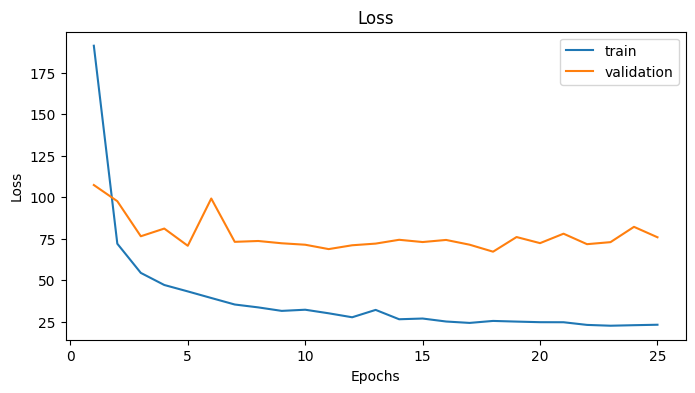

In [6]:
plot_loss(history, "Loss", start=0)

In [ ]:
model = load_model("model_19_mag")

In [7]:
pred_limit = 32
predictions, targets = predict_polar(
    model,
    test_data_loader,
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part],
    limit=pred_limit,
    from_db=part=="db")

08_Gtr_Gs_3/chunk_0, 08_Gtr_Gs_3/chunk_1, 08_Gtr_Gs_3/chunk_2, 08_Gtr_Gs_3/chunk_3
08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3


--------------------------------------------------
08_Gtr_Gs_3/chunk_4, 08_Gtr_Gs_3/chunk_5, 08_Gtr_Gs_3/chunk_6, 08_Gtr_Gs_3/chunk_7
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Gtr_Gs_3/chunk_8, 08_Gtr_Gs_3/chunk_9, 08_Gtr_Gs_3/chunk_10, 08_Gtr_Gs_3/chunk_11
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Gtr_Gs_3/chunk_12, 08_Gtr_Gs_3/chunk_13, 08_Gtr_Gs_3/chunk_14, 08_Gtr_Gs_3/chunk_15
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Gtr_Gs_3/chunk_16, 08_Gtr_Gs_3/chunk_17, 08_Gtr_Gs_3/chunk_18, 08_Gtr_Gs_3/chunk_19
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Gtr_Gs_3/chunk_20, 08_Gtr_Gs_3/chunk_21, 08_Gtr_Gs_3/chunk

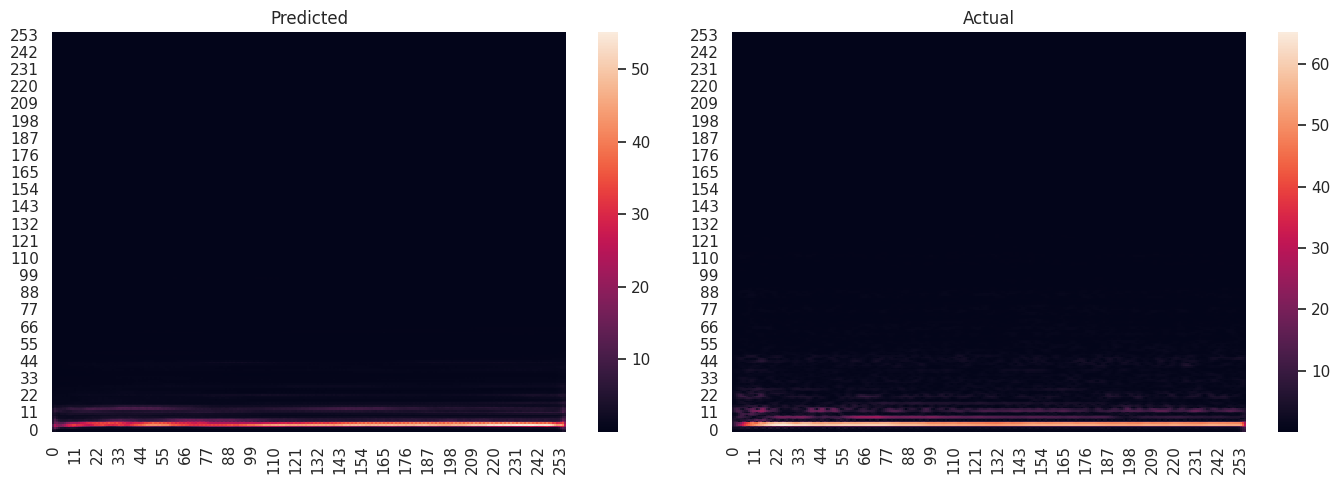

In [8]:
plot_heatmaps(predictions[0], targets[0])

In [9]:
_, test_data_loader_phase = build_data_loaders(
    min_max, part="phase", test_size=test_size)
phases = get_phases(test_data_loader_phase,
                    instrument="ney",
                    limit=pred_limit)

08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Ney_Gs_3/chunk_20, 08_Ney_Gs_3/chunk_21, 08_Ney_Gs_3/chunk_22, 08_Ney_Gs_3/chunk_23
--------------------------------------------------
08_Ney_Gs_3/chunk_24, 08_Ney_Gs_3/chunk_25, 08_Ney_Gs_3/chunk_26, 08_Ney_Gs_3/chunk_27
--------------------------------------------------
08_Ney_Gs_3/chunk_28, 08_Ney_Gs_3/chunk_29, 

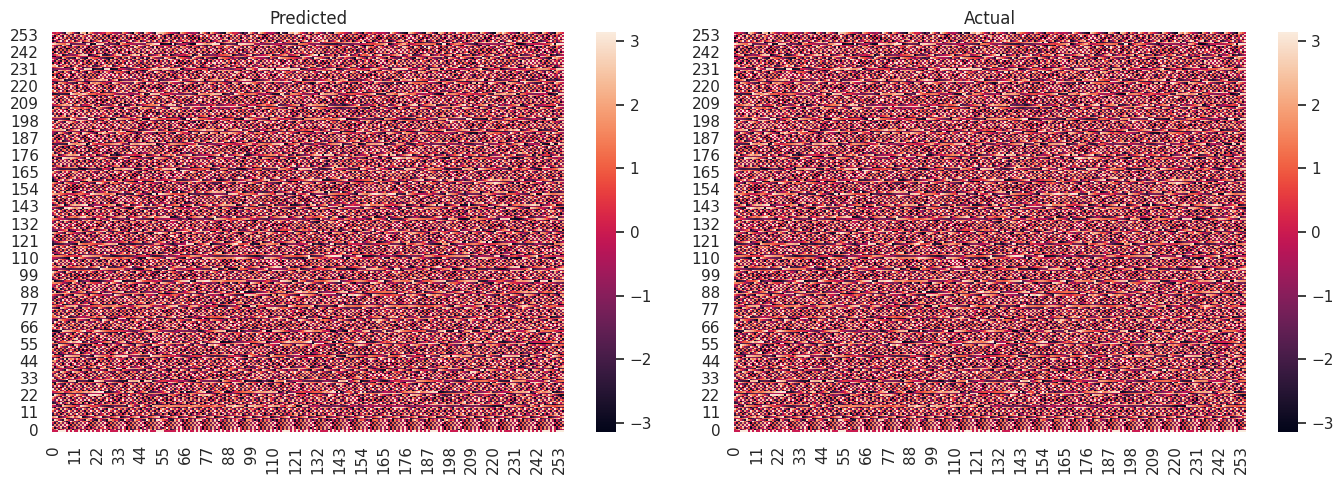

In [11]:
plot_heatmaps(phases[0], phases[0])

48064 48064


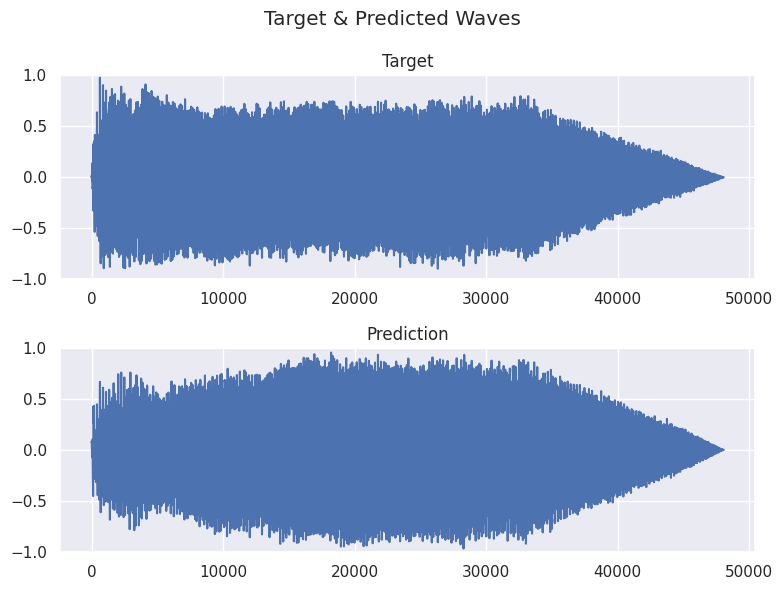

In [10]:
wave_prediction = make_wav(predictions, phases)
wave_target = make_wav(targets, phases)
print(len(wave_prediction), len(wave_target))
plot_waves(wave_target, wave_prediction)

In [ ]:
ipd.Audio(wave_target, rate=SR)

In [ ]:
ipd.Audio(wave_prediction, rate=SR)

In [11]:
sf.write("z_target.wav", wave_target, SR, format="wav")
sf.write("z_prediction.wav", wave_prediction, SR, format="wav")

In [ ]:
save_model(model, "model_2_mag_2b_16feat")